# Identification of digits from sign language images 

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import relevant libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Image Settings
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2

In [4]:
# Define get images function
def get_img(data_path):
    # Getting image array from path:
    img = cv2.imread(data_path)
    img = cv2.resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img

## Analyze dataset

Number of samples for digit 0: 205
Number of samples for digit 1: 206
Number of samples for digit 2: 206
Number of samples for digit 3: 206
Number of samples for digit 4: 207
Number of samples for digit 5: 207
Number of samples for digit 6: 207
Number of samples for digit 7: 206
Number of samples for digit 8: 208
Number of samples for digit 9: 204


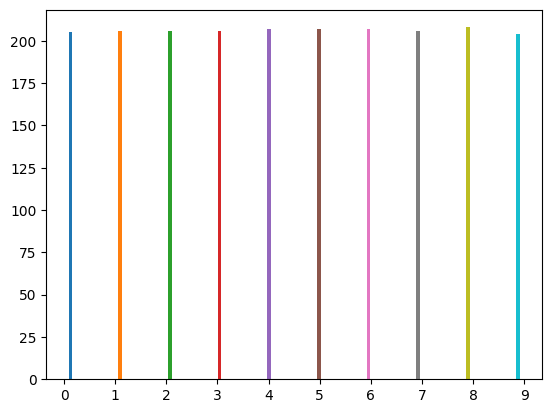

In [5]:
# Plot the number of samples for each sign languagem digit
dataset_path = "dataset/raw/"
data_distribution = {}

labels = os.listdir(dataset_path)  # Getting labels
labels.sort()  # Sorting labels
for i, label in enumerate(labels):
    data_path = dataset_path + label
    for img in os.listdir(data_path):
        img_path = data_path + "/" + img
        img_read = cv2.imread(img_path)

        if label in data_distribution:
            data_distribution[label].append(img_read)
        else:
            data_distribution[label] = [img_read]
    

for label in data_distribution:
    print("Number of samples for digit " + label + ": " + str(len(data_distribution[label])))

#TODO: Plot a better histogram (label each bar with the total number of samples)
counts, edges, bars = plt.hist([[key]*len(data_distribution[key]) for key in data_distribution.keys()], bins=10)
plt.show()
        

- We have a pretty balanced dataset

## Data Preprocessing 

For the preprocessing we will be resizing and converting each image to grayscale. We will also be flatening them

In [6]:
# Resize function
def resize(img):
    width = 50
    height = 50
    dim = (width, height)

    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

# Convert image to grayscale
def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

# Flatten image
def flatten(img):
    data = np.array(img)

    flattened = data.flatten()
    return flattened

In [7]:
# Define Save and Load Model functions

import pickle
def save_model(filename, model):
    pickle.dump(model, open("models/"+filename, 'wb'))

def load_model(filename):
    return pickle.load(open("models/"+filename, 'rb'))


In [8]:
# Deal with the dataset images

images = []
labels = []

for label in data_distribution:
    for img in data_distribution[label]:
        img_resized = resize(img)
        img_grayscale = grayscale(img_resized)
        img_flattened = flatten(img_grayscale)

        images.append(img_flattened)
        labels.append(label)
images = np.asarray(images)
labels = np.asarray(labels)

In [9]:
# Split data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=58)   

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1649, 2500) (1649,)
(413, 2500) (413,)


In [10]:
# Define train and analyse model functions
from sklearn.model_selection import GridSearchCV, KFold, validation_curve, cross_validate


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def train_and_analyze(model, X_train, y_train, X_test, y_test):
    trained_model = model.fit(X_train, y_train)
    
    print(f"> Model: {model.__class__}\n")
    
    X_test_prediction = model.predict(X_test)
    test_data_accuracy = accuracy_score(X_test_prediction, y_test)
    f1 = f1_score(y_test, X_test_prediction, average='weighted')

    print()
    print("---- Model Analysis ----")
    print('Accuracy: ', test_data_accuracy)
    print('F1 Score: ', f1)
    
    print()
    
    print("Confusion Matrix: ")
    cm = confusion_matrix(y_test, model.predict(X_test))
    plot_confusion_matrix(cm, target_names=[str(i) for i in range(10)], normalize=False)
    plt.show()
    
    print()
    print("---- Classification Report ----")
    print(classification_report(y_test, model.predict(X_test)))

    return trained_model

def hyperparameters(model, params, X, y):
    """
    Find hyperparameters for a model
    """
    print("> Hyper Parameter Tuning")
    print("Finding Best Params for Model ", model.__class__)
    model = GridSearchCV(model, params, scoring="accuracy")
    model.fit(X, y)
    print(" Best Params: ")
    print(model.best_params_)
    
    return model.best_params_


def kfold(model, k, X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=k, shuffle=True)
    scores = cross_validate(model, X_train, y_train, scoring="accuracy", cv=k, return_estimator=True)
    return scores["estimator"][np.argmax(scores["test_score"])]

# Basic Models without Parameter Tuning

## Logistic Regression

> Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


---- Model Analysis ----
Accuracy:  0.7699757869249395
F1 Score:  0.7718090845039223

Confusion Matrix: 


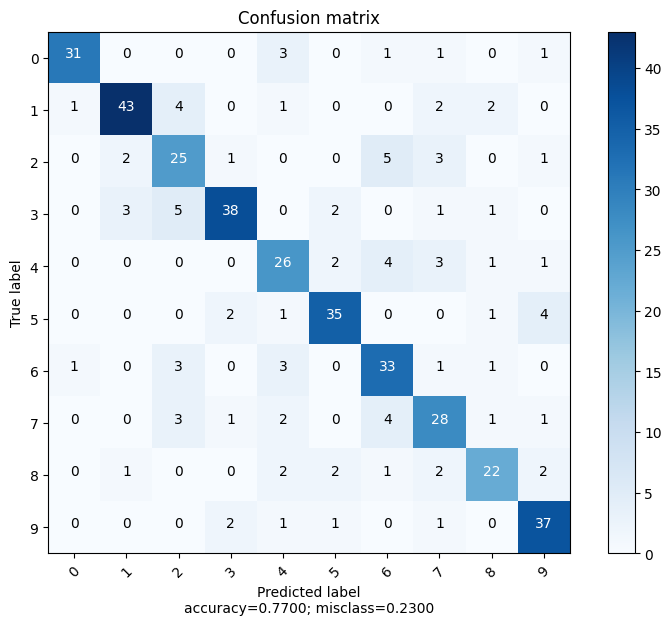


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        37
           1       0.88      0.81      0.84        53
           2       0.62      0.68      0.65        37
           3       0.86      0.76      0.81        50
           4       0.67      0.70      0.68        37
           5       0.83      0.81      0.82        43
           6       0.69      0.79      0.73        42
           7       0.67      0.70      0.68        40
           8       0.76      0.69      0.72        32
           9       0.79      0.88      0.83        42

    accuracy                           0.77       413
   macro avg       0.77      0.77      0.77       413
weighted avg       0.78      0.77      0.77       413



In [11]:
from sklearn.linear_model import LogisticRegression
logisticRegr = train_and_analyze(LogisticRegression(), x_train, y_train, x_test, y_test)

save_model("logistic_regression.sav", logisticRegr)

## Decision Tree Model

> Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>


---- Model Analysis ----
Accuracy:  0.576271186440678
F1 Score:  0.5825685561927355

Confusion Matrix: 


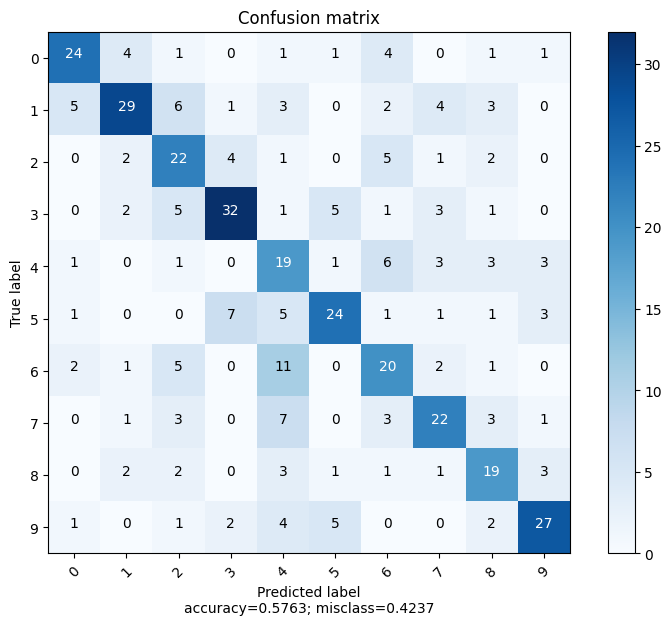


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.71      0.65      0.68        37
           1       0.71      0.55      0.62        53
           2       0.48      0.59      0.53        37
           3       0.70      0.64      0.67        50
           4       0.35      0.51      0.41        37
           5       0.65      0.56      0.60        43
           6       0.47      0.48      0.47        42
           7       0.59      0.55      0.57        40
           8       0.53      0.59      0.56        32
           9       0.71      0.64      0.67        42

    accuracy                           0.58       413
   macro avg       0.59      0.58      0.58       413
weighted avg       0.60      0.58      0.58       413



In [12]:
from sklearn import tree
clf = train_and_analyze(tree.DecisionTreeClassifier(), x_train, y_train, x_test, y_test)

save_model("decision_tree.sav", clf)


## Random Forest Classifier

> Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


---- Model Analysis ----
Accuracy:  0.7917675544794189
F1 Score:  0.7935977500775093

Confusion Matrix: 


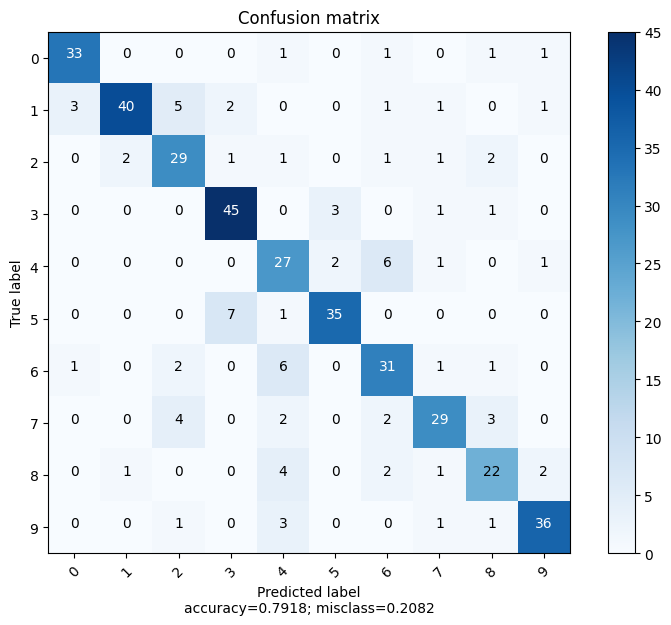


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        37
           1       0.93      0.75      0.83        53
           2       0.71      0.78      0.74        37
           3       0.82      0.90      0.86        50
           4       0.60      0.73      0.66        37
           5       0.88      0.81      0.84        43
           6       0.70      0.74      0.72        42
           7       0.81      0.72      0.76        40
           8       0.71      0.69      0.70        32
           9       0.88      0.86      0.87        42

    accuracy                           0.79       413
   macro avg       0.79      0.79      0.79       413
weighted avg       0.80      0.79      0.79       413



In [13]:
from sklearn.ensemble import RandomForestClassifier
clf_rft = train_and_analyze(RandomForestClassifier(), x_train, y_train, x_test, y_test)

save_model("random_forest.sav", clf_rft)


## Naive Bayes

> Model: <class 'sklearn.naive_bayes.GaussianNB'>


---- Model Analysis ----
Accuracy:  0.6222760290556901
F1 Score:  0.6245230763867611

Confusion Matrix: 


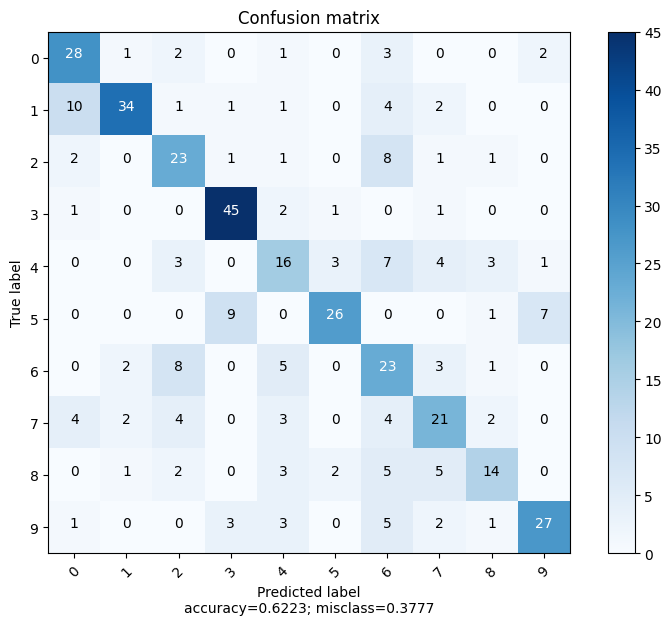


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.61      0.76      0.67        37
           1       0.85      0.64      0.73        53
           2       0.53      0.62      0.57        37
           3       0.76      0.90      0.83        50
           4       0.46      0.43      0.44        37
           5       0.81      0.60      0.69        43
           6       0.39      0.55      0.46        42
           7       0.54      0.53      0.53        40
           8       0.61      0.44      0.51        32
           9       0.73      0.64      0.68        42

    accuracy                           0.62       413
   macro avg       0.63      0.61      0.61       413
weighted avg       0.64      0.62      0.62       413



In [14]:
from sklearn.naive_bayes import GaussianNB 
gnb = train_and_analyze(GaussianNB(), x_train, y_train, x_test, y_test)

save_model("naive_bayes.sav", gnb)

## SVM

> Model: <class 'sklearn.svm._classes.SVC'>


---- Model Analysis ----
Accuracy:  0.8523002421307506
F1 Score:  0.8546210562809349

Confusion Matrix: 


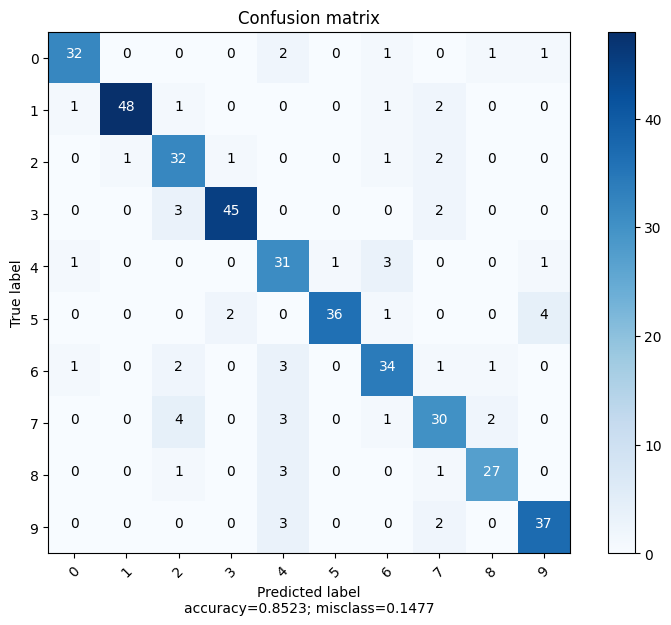


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        37
           1       0.98      0.91      0.94        53
           2       0.74      0.86      0.80        37
           3       0.94      0.90      0.92        50
           4       0.69      0.84      0.76        37
           5       0.97      0.84      0.90        43
           6       0.81      0.81      0.81        42
           7       0.75      0.75      0.75        40
           8       0.87      0.84      0.86        32
           9       0.86      0.88      0.87        42

    accuracy                           0.85       413
   macro avg       0.85      0.85      0.85       413
weighted avg       0.86      0.85      0.85       413



In [16]:
from sklearn.svm import SVC

svm = train_and_analyze(SVC(), x_train, y_train, x_test, y_test)

save_model("svm.sav", svm) 


## Neural Networks 

> Model: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


---- Model Analysis ----
Accuracy:  0.08958837772397095
F1 Score:  0.014732311003497443

Confusion Matrix: 


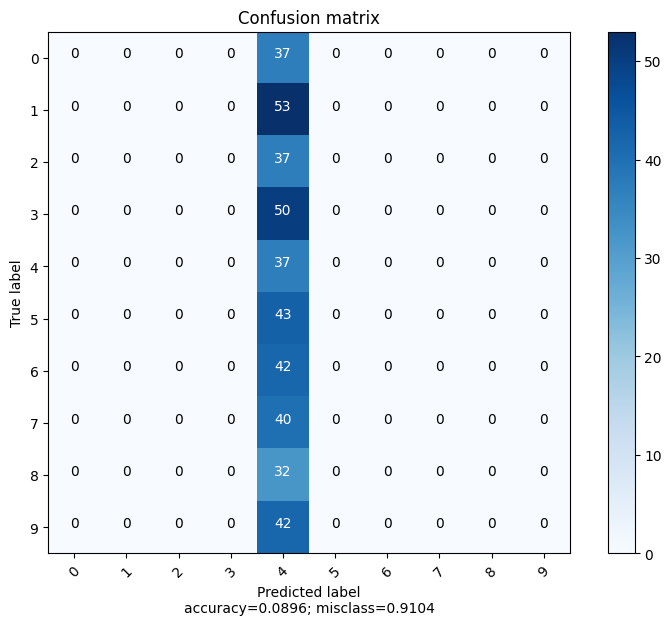


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        50
           4       0.09      1.00      0.16        37
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        40
           8       0.00      0.00      0.00        32
           9       0.00      0.00      0.00        42

    accuracy                           0.09       413
   macro avg       0.01      0.10      0.02       413
weighted avg       0.01      0.09      0.01       413



In [17]:
from sklearn.neural_network import MLPClassifier

NN = train_and_analyze(MLPClassifier(), x_train, y_train, x_test, y_test)

save_model("neural_network.sav", NN)

## Gradient Descent Classifier

> Model: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


---- Model Analysis ----
Accuracy:  0.7457627118644068
F1 Score:  0.7519600069382832

Confusion Matrix: 


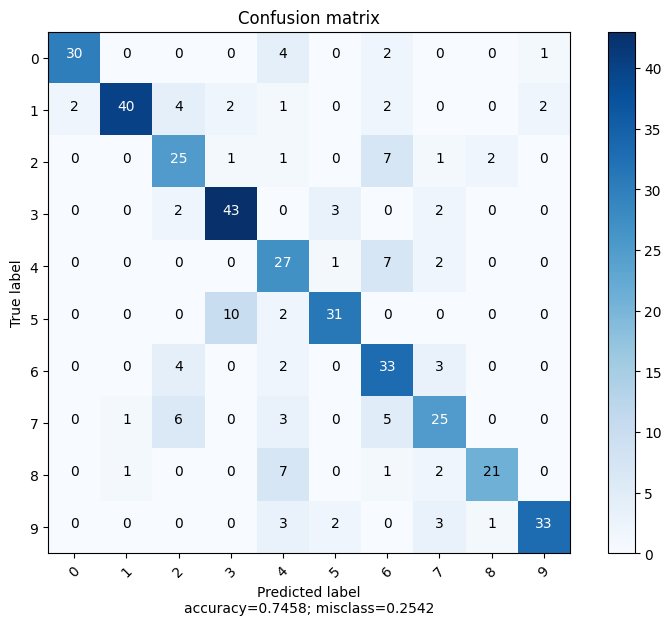


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        37
           1       0.95      0.75      0.84        53
           2       0.61      0.68      0.64        37
           3       0.77      0.86      0.81        50
           4       0.54      0.73      0.62        37
           5       0.84      0.72      0.77        43
           6       0.58      0.79      0.67        42
           7       0.66      0.62      0.64        40
           8       0.88      0.66      0.75        32
           9       0.92      0.79      0.85        42

    accuracy                           0.75       413
   macro avg       0.77      0.74      0.75       413
weighted avg       0.77      0.75      0.75       413



In [18]:
from sklearn.ensemble import GradientBoostingClassifier

gdc = train_and_analyze(GradientBoostingClassifier(), x_train, y_train, x_test, y_test)

save_model("gradient_descent.sav", gdc)

## Models with Hypertuned Parameters & Cross-Validation

## Logistic Regression

> Hyper Parameter Tuning
Finding Best Params for Model  <class 'sklearn.linear_model._logistic.LogisticRegression'>
 Best Params: 
{'C': 1000, 'class_weight': 'balanced', 'max_iter': 400, 'penalty': 'l1', 'solver': 'liblinear'}
> Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


---- Model Analysis ----
Accuracy:  0.7021791767554479
F1 Score:  0.7089559496748015

Confusion Matrix: 


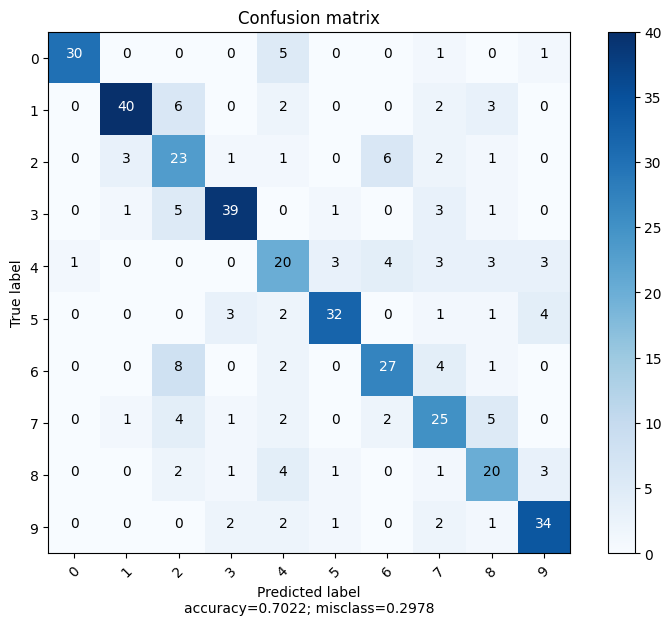


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.97      0.81      0.88        37
           1       0.89      0.75      0.82        53
           2       0.48      0.62      0.54        37
           3       0.83      0.78      0.80        50
           4       0.50      0.54      0.52        37
           5       0.84      0.74      0.79        43
           6       0.69      0.64      0.67        42
           7       0.57      0.62      0.60        40
           8       0.56      0.62      0.59        32
           9       0.76      0.81      0.78        42

    accuracy                           0.70       413
   macro avg       0.71      0.70      0.70       413
weighted avg       0.72      0.70      0.71       413



In [19]:
hypertuned_model = LogisticRegression()

logreg_params = [{'solver': ['liblinear'], 'max_iter': [100, 400, 800],
                         'C': [0.1, 1, 10, 100, 1000], 'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2']}]
best_logreg_params = hyperparameters(LogisticRegression(), logreg_params , x_train, y_train)
hypertuned_model.set_params(**best_logreg_params)

hypertuned_model = train_and_analyze(hypertuned_model, x_train, y_train, x_test, y_test)

save_model("/tuned/logistic_regression_tuned.sav", hypertuned_model)

> Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


---- Model Analysis ----
Accuracy:  0.7046004842615012
F1 Score:  0.7110676780769706

Confusion Matrix: 


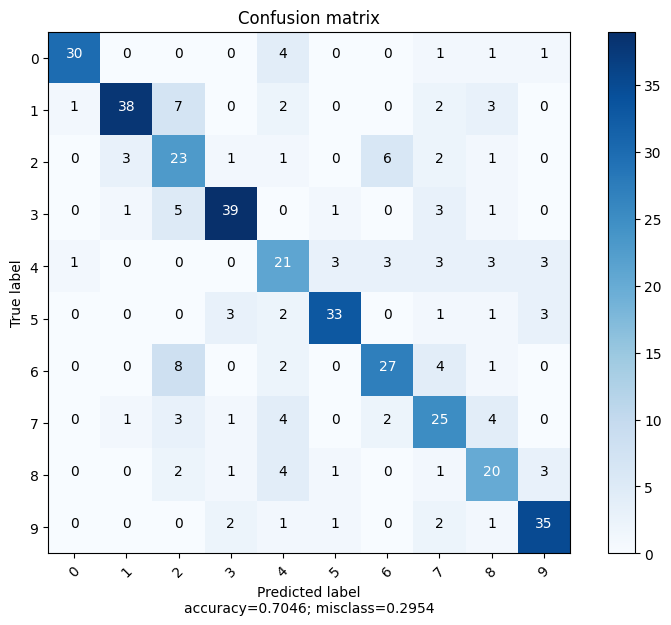


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        37
           1       0.88      0.72      0.79        53
           2       0.48      0.62      0.54        37
           3       0.83      0.78      0.80        50
           4       0.51      0.57      0.54        37
           5       0.85      0.77      0.80        43
           6       0.71      0.64      0.67        42
           7       0.57      0.62      0.60        40
           8       0.56      0.62      0.59        32
           9       0.78      0.83      0.80        42

    accuracy                           0.70       413
   macro avg       0.71      0.70      0.70       413
weighted avg       0.72      0.70      0.71       413



In [21]:
logreg_kfmodel = kfold(hypertuned_model, 5, x_train, y_train, x_test, y_test)

logreg_kfmodel = train_and_analyze(logreg_kfmodel, x_train, y_train, x_test, y_test)

save_model("/CV/logistic_regression_cv.sav", logreg_kfmodel)

## SVM

> Hyper Parameter Tuning
Finding Best Params for Model  <class 'sklearn.svm._classes.SVC'>
 Best Params: 
{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
> Model: <class 'sklearn.svm._classes.SVC'>


---- Model Analysis ----
Accuracy:  0.0774818401937046
F1 Score:  0.011143455668308079

Confusion Matrix: 


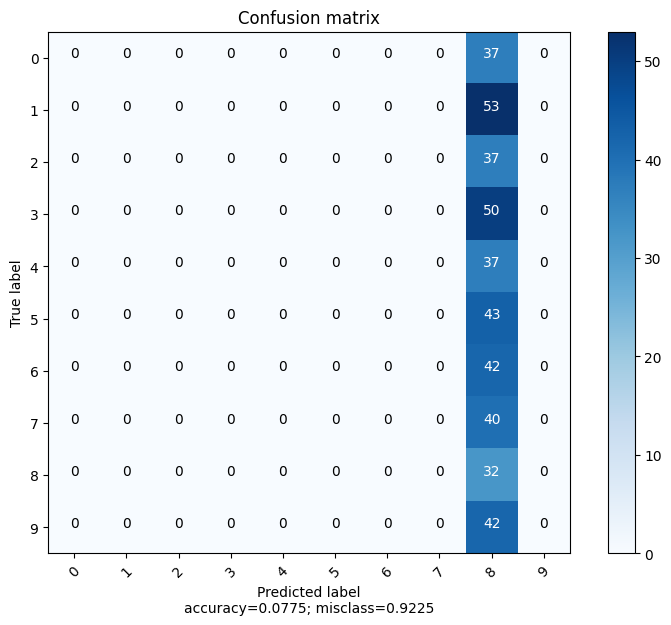


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        40
           8       0.08      1.00      0.14        32
           9       0.00      0.00      0.00        42

    accuracy                           0.08       413
   macro avg       0.01      0.10      0.01       413
weighted avg       0.01      0.08      0.01       413



In [22]:
hypertuned_model = SVC()

svm_parameters = [{'C': [0.01, 0.1, 1, 10, 50, 100, 1000], 
              'gamma': [0.001, 0.01, 0.03, 0.1, 0.3, 1],
              'kernel': ['rbf']}]
best_svm_parameters = hyperparameters(SVC(), svm_parameters , x_train, y_train)
hypertuned_model.set_params(**best_svm_parameters)

hypertuned_model = train_and_analyze(hypertuned_model, x_train, y_train, x_test, y_test)

save_model("/tuned/SVM_tuned.sav", hypertuned_model)

> Model: <class 'sklearn.svm._classes.SVC'>


---- Model Analysis ----
Accuracy:  0.0774818401937046
F1 Score:  0.011143455668308079

Confusion Matrix: 


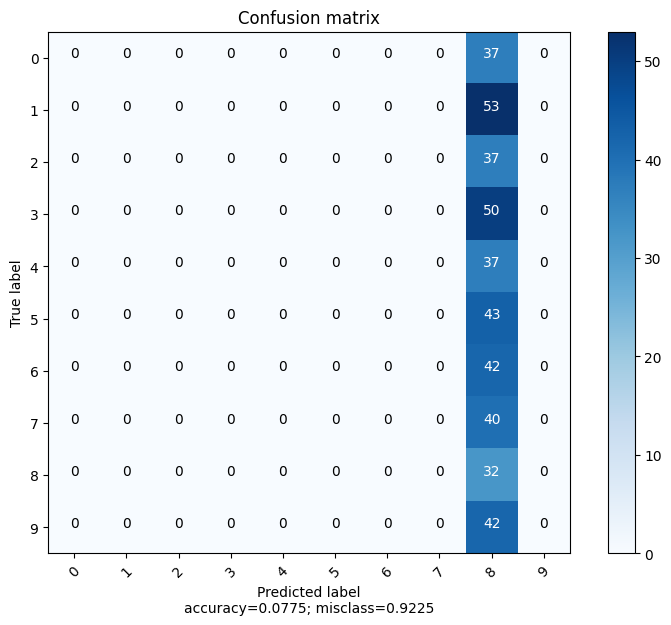


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        40
           8       0.08      1.00      0.14        32
           9       0.00      0.00      0.00        42

    accuracy                           0.08       413
   macro avg       0.01      0.10      0.01       413
weighted avg       0.01      0.08      0.01       413



In [23]:
svm_kfmodel = kfold(hypertuned_model, 5, x_train, y_train, x_test, y_test)

svm_kfmodel = train_and_analyze(svm_kfmodel, x_train, y_train, x_test, y_test)

save_model("/CV/svm_cv.sav", svm_kfmodel)

## Neural Networks

> Hyper Parameter Tuning
Finding Best Params for Model  <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
 Best Params: 
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (12, 12, 12), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_iter': 1000, 'solver': 'adam'}
> Model: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


---- Model Analysis ----
Accuracy:  0.0774818401937046
F1 Score:  0.011143455668308079

Confusion Matrix: 


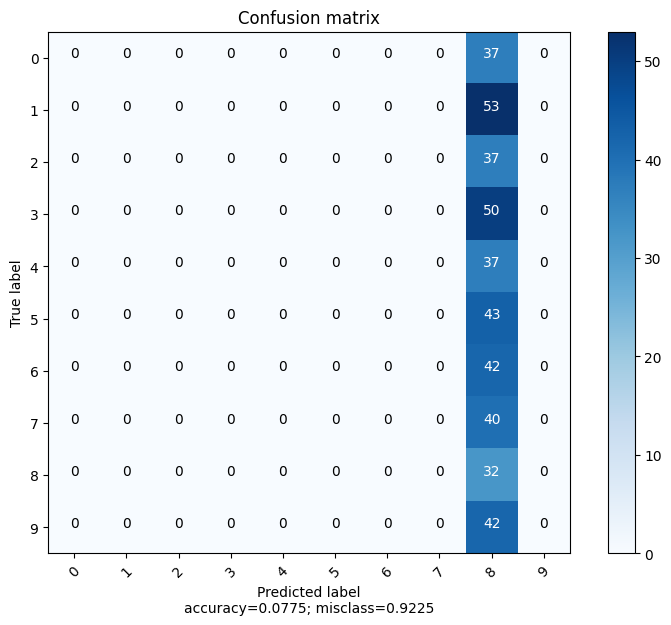


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        40
           8       0.08      1.00      0.14        32
           9       0.00      0.00      0.00        42

    accuracy                           0.08       413
   macro avg       0.01      0.10      0.01       413
weighted avg       0.01      0.08      0.01       413



In [24]:
hypertuned_model = MLPClassifier()

nn_parameters = [{'solver': ['adam'], 'max_iter': [1000],
                     'hidden_layer_sizes': [(12,12), (12,12,12)], 'activation': ['tanh', 'relu'],
                     'alpha': [1e-3,1e-4], 'learning_rate': ['constant', 'invscaling'], 
                     'learning_rate_init': [0.001, 0.01]}]

best_nn_parameters = hyperparameters(MLPClassifier(), nn_parameters , x_train, y_train)
hypertuned_model.set_params(**best_nn_parameters)

hypertuned_model = train_and_analyze(hypertuned_model, x_train, y_train, x_test, y_test)

save_model("/tuned/NN_tuned.sav", hypertuned_model)

> Model: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


---- Model Analysis ----
Accuracy:  0.0774818401937046
F1 Score:  0.011143455668308079

Confusion Matrix: 


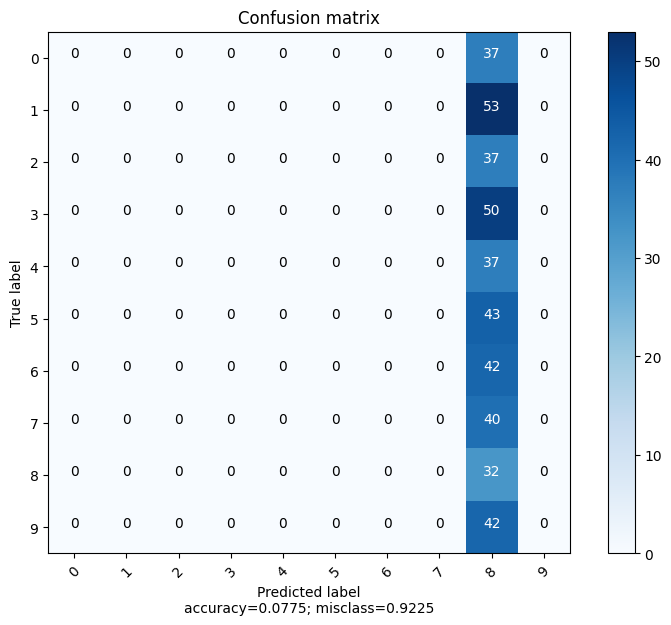


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        40
           8       0.08      1.00      0.14        32
           9       0.00      0.00      0.00        42

    accuracy                           0.08       413
   macro avg       0.01      0.10      0.01       413
weighted avg       0.01      0.08      0.01       413



In [25]:
nn_kfmodel = kfold(hypertuned_model, 5, x_train, y_train, x_test, y_test)

nn_kfmodel = train_and_analyze(nn_kfmodel, x_train, y_train, x_test, y_test)

save_model("/CV/nn_cv.sav", nn_kfmodel)

## Random Forest Classifier

In [26]:
hypertuned_model = RandomForestClassifier()

rf_parameters = {
    'n_estimators': [50, 100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

best_rf_parameters = hyperparameters(RandomForestClassifier(), rf_parameters , x_train, y_train)
hypertuned_model.set_params(**best_rf_parameters)

hypertuned_model = train_and_analyze(hypertuned_model, x_train, y_train, x_test, y_test)

save_model("/tuned/rf_tuned.sav", hypertuned_model)

> Hyper Parameter Tuning
Finding Best Params for Model  <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [ ]:
rf_kfmodel = kfold(hypertuned_model, 5, x_train, y_train, x_test, y_test)

rf_kfmodel = train_and_analyze(rf_kfmodel, x_train, y_train, x_test, y_test)

save_model("/CV/rf_cv.sav", rf_kfmodel)